### 1. Imports

In [8]:
import os
import pandas as pd
import numpy as np
from lcfunctions import download_alerce_lc, download_lasair_lc, display_lightcurve
from lcfunctions import lasair_clean, load_lasair_lc
from scipy.signal import find_peaks
from scipy.stats import linregress

### 2. Load dataframe of AAVSO CVs in ZTF

In [2]:
# Load dataset
df_ZTF_CVs = pd.read_csv('../processed_data/AAVSOCVsZTFxmatch_21032023_BTS_labelled.csv')
# test = pd.read_csv('../processed_data/AAVSOCVsZTFxmatch_21032023_BTS_manual_labelled.xlsm')

df_ZTF_CVs.CV_Types.value_counts()

dwarf_nova            4822
nova_like              263
polar                  126
nova                    88
intermediate_polar      54
AMCVn                   46
Name: CV_Types, dtype: int64

In [3]:
# List of objects.
lst = df_ZTF_CVs.Xmatch_obj.to_list()
# Check length of objects list
print(f'Length of list of objects: {len(lst)}')

Length of list of objects: 5708


### Display light curves

In [4]:
date = '2023_03_25'

manuallist = True

# Apply errorbars
error = False

if error == True:
        errCollasair1 = 'sigmapsf'
        errCollasair2 = 'dc_sigmag'
else:
    errCollasair1 = None
    errCollasair2 = None

objlist = df_ZTF_CVs[df_ZTF_CVs['Type'].str.contains('UGSS', na=False)]['Xmatch_obj'].iloc[20:40]
objtype = df_ZTF_CVs[df_ZTF_CVs['Type'].str.contains('UGSS', na=False)]['Type'].iloc[20:40]

if manuallist==True:
     objlist = ['ZTF18abajshu','ZTF18aagrgoe','ZTF18abchhxd','ZTF18aabfcyi','ZTF18abnzbxh','ZTF18acrsmyu','ZTF21abhrevv',
                'ZTF18abavrji','ZTF18aanwrti','ZTF18aammncw','ZTF19abzzuin','ZTF18acyerom','ZTF20abgbxco','ZTF18achemir',
                'ZTF18abmaqoi','ZTF18adlkmio','ZTF18abiwtyk','ZTF18aaueblh','ZTF18aakvuwy','ZTF18abcnbki','ZTF18abakkox']

i=0
for object, type in zip(objlist, objtype):
    print(i, object, type)
    
    # Display lasair difference magnitude and apparent magnitude light curves.
    lc_lasair = load_lasair_lc(object, path=f'../lightcurves_dataset/lasair_{date}')
    lc_lasair_appmag = lasair_clean(lc_lasair, limit=25, magerrlim=1)

    # print('Lasair difference magnitude')
    # display_lightcurve(lc_lasair,x='jd',y='magpsf',errorCol=errCollasair1)
    print('Lasair apparent magnitude')
    display_lightcurve(lc_lasair_appmag,x='jd',y='dc_mag',errorCol=errCollasair2)
    i+=1


0 ZTF18abajshu UGSS
Lasair apparent magnitude


1 ZTF18aagrgoe UGSS
Lasair apparent magnitude


2 ZTF18abchhxd UGSS
Lasair apparent magnitude


3 ZTF18aabfcyi UGSS
Lasair apparent magnitude


4 ZTF18abnzbxh UGSS
Lasair apparent magnitude


5 ZTF18acrsmyu UGSS
Lasair apparent magnitude


6 ZTF21abhrevv UGSS
Lasair apparent magnitude


7 ZTF18abavrji UGSS
Lasair apparent magnitude


8 ZTF18aanwrti UGSS
Lasair apparent magnitude


9 ZTF18aammncw UGSS
Lasair apparent magnitude


10 ZTF19abzzuin UGSS
Lasair apparent magnitude


11 ZTF18acyerom UGSS
Lasair apparent magnitude


12 ZTF20abgbxco UGSS
Lasair apparent magnitude


13 ZTF18achemir UGSS
Lasair apparent magnitude


14 ZTF18abmaqoi UGSS
Lasair apparent magnitude


15 ZTF18adlkmio UGSS
Lasair apparent magnitude


16 ZTF18abiwtyk UGSS
Lasair apparent magnitude


17 ZTF18aaueblh UGSS
Lasair apparent magnitude


18 ZTF18aakvuwy UGSS
Lasair apparent magnitude


19 ZTF18abcnbki UGSS
Lasair apparent magnitude


### Formulate functions for the features you wish to extract.

In [5]:
# Method for finding standstills in Z_Cam light curves
def standstill_finder(lc, pnt_threshold=20, window_size=10):
    # Reverse light curve
    lc_rev = lc.copy()
    # subtract median magnitude from each filter and multiply by -1 to flip the light curve
    lc_rev['dc_mag'] = (lc_rev['dc_mag'] - lc_rev['dc_mag'].median())*(-1)

    # # Convert jd to ingeter
    # lc['jd'] = lc['jd'].astype(int)
    # # for a given filter, if the same jd is repeated, keep the first one
    # lc = lc.drop_duplicates(subset=['jd', 'fid'], keep='first')

    # Rolling standard deviation for light curves with equal to or more than pnt_threshold
    if len(lc_rev) >= pnt_threshold:
        # Rolling standard deviation for window size
        roll_std = lc_rev['dc_mag'].rolling(window_size).std()
        # Rolling mean for window size
        roll_mean = lc_rev['dc_mag'].rolling(window_size).mean()
        # Maximum and minimum of light curve
        lc_max = lc_rev['dc_mag'].max()
        lc_min = lc_rev['dc_mag'].min()
        # index of minimum of rolling standard deviation
        min_roll_std = roll_std.idxmin()
        # mean of the window with the minimum rolling standard deviation
        min_roll_std_mean = roll_mean[min_roll_std]
        # fraction of the maximum light curve amplitude that min_roll_std_mean is, i.e., location relative to the maximum of the standstill.
        standstill_level = (min_roll_std_mean-lc_min)/(lc_max-lc_min)

        print(f'Rolling std max: {roll_std.max()}',
            f'\nRolling std min: {roll_std.min()}',
            f'\nRatio of max and min of rolling std: {roll_std.max()/roll_std.min()}',
            f'\nMean brightness of window with minimum rolling std: {min_roll_std_mean}'
            f'\nStandstill level: {standstill_level}')
        
        return roll_std.max(), roll_std.min(), roll_std.max()/roll_std.min(), min_roll_std_mean, standstill_level
    else:
        return np.nan, np.nan, np.nan, np.nan, np.nan


def peak_definer(lc, height=None, threshold=None, distance=None, prominence=(2,5), 
                     width=None, wlen=None, rel_height=0.5, plateau_size=None):
        
        # Reverse light curve
        lc_rev = lc.copy()
        # subtract median magnitude from each filter and multiply by -1 to flip the light curve
        lc_rev['dc_mag'] = (lc_rev['dc_mag'] - lc_rev['dc_mag'].median())*(-1)

        # Find peaks in the light curve
        peaks, properties = find_peaks(lc_rev['dc_mag'], 
                                    height=height, 
                                    threshold=threshold, 
                                    distance=distance, 
                                    prominence=prominence, 
                                    width=width, 
                                    wlen=wlen,
                                    rel_height=rel_height, 
                                    plateau_size=plateau_size)


        if len(peaks)>0:
            # Get the times of the peaks and the times of the left and right edges of the peaks
            peak_times = lc_rev.iloc[peaks]['jd'].values
            n_peaks = len(peak_times)
            times_left_bases = lc_rev.iloc[properties['left_bases']]['jd'].values
            times_right_bases = lc_rev.iloc[properties['right_bases']]['jd'].values
            max_prominence = properties['prominences'].max()
            rise_rate = np.mean(properties['prominences']/(peak_times-times_left_bases))
            decline_rate = np.mean(properties['prominences']/(times_right_bases-peak_times))
        
        elif len(peaks)==0:
            try:
                linreg = linregress(lc['jd'], lc['dc_mag'])
                if (linreg.pvalue < 0.05) & (linreg.slope < 0):
                    n_peaks = 0
                    rise_rate = np.nan
                    decline_rate = linreg.slope*(-1)
                    max_prominence = np.nan
                else:
                    n_peaks = 0
                    rise_rate = np.nan
                    decline_rate = np.nan
                    max_prominence = np.nan
                
            except:
                n_peaks = 0
                rise_rate = np.nan
                decline_rate = np.nan
                max_prominence = np.nan

    
        print(f'Number of peaks: {n_peaks}',
              f'\nRise rate: {rise_rate}',
              f'\nDecline rate: {decline_rate}',
              f'\nMax prominence: {max_prominence}')

        
        import matplotlib.pyplot as plt 
        plt.figure(figsize=(12,2.5))
        plt.scatter(lc_rev['jd'], lc_rev['dc_mag'],s=10)
        plt.scatter(lc_rev.iloc[peaks]['jd'], lc_rev.iloc[peaks]['dc_mag'], s=10,c='r')
        plt.show()

        return n_peaks, rise_rate, decline_rate, max_prominence


### Test some features

ZTF18abajshu EA+NL


Rolling std max: 1.531868984962103 
Rolling std min: 0.041136338796442753 
Ratio of max and min of rolling std: 37.238826540746274 
Mean brightness of window with minimum rolling std: -0.02879728088541835
Standstill level: 0.871664787747288
Number of peaks: 18 
Rise rate: 0.18588793767668832 
Decline rate: 0.17637882589467904 
Max prominence: 3.7783133026462643


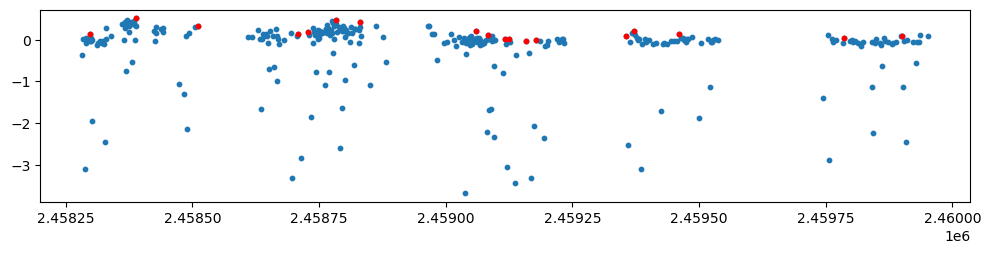

ZTF18aagrgoe NA+NL/VY


Rolling std max: 0.24824877097842232 
Rolling std min: 0.03328265059519745 
Ratio of max and min of rolling std: 7.458804107814767 
Mean brightness of window with minimum rolling std: -0.31516391668694244
Standstill level: 0.22128212679822154
Number of peaks: 0 
Rise rate: nan 
Decline rate: nan 
Max prominence: nan


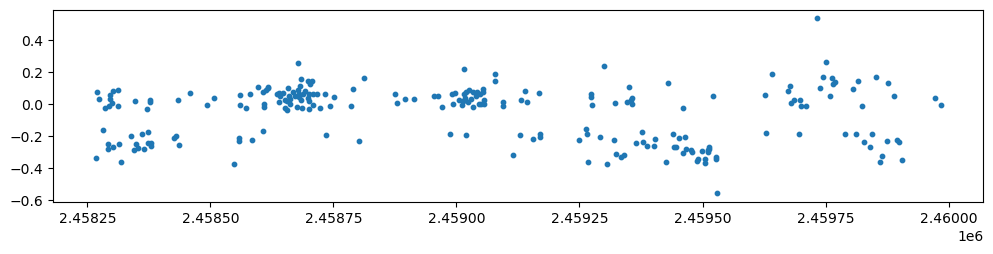

ZTF18abchhxd NA+NL/VY


Rolling std max: 0.5590812401704486 
Rolling std min: 0.029338240827392562 
Ratio of max and min of rolling std: 19.056399579638224 
Mean brightness of window with minimum rolling std: 0.7401384249693944
Standstill level: 0.8765726524834118
Number of peaks: 0 
Rise rate: nan 
Decline rate: nan 
Max prominence: nan


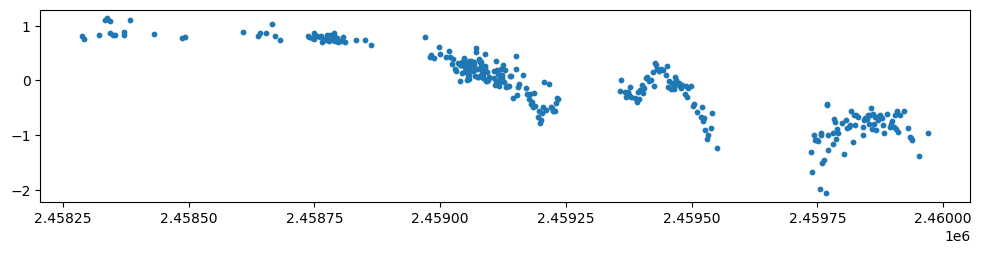

ZTF18aabfcyi UGSU


Rolling std max: 2.1217705264723943 
Rolling std min: 0.17433574855754427 
Ratio of max and min of rolling std: 12.170599226079245 
Mean brightness of window with minimum rolling std: -0.25910602909720454
Standstill level: 0.18255796018810502
Number of peaks: 61 
Rise rate: 0.44922725710893724 
Decline rate: 0.5544668481104543 
Max prominence: 4.83683646251386


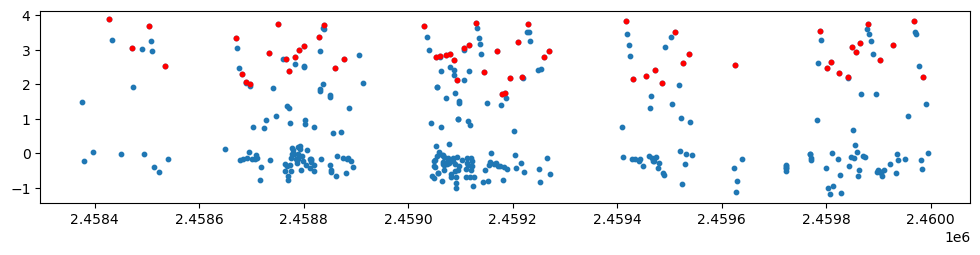

ZTF18abnzbxh UGSU


Rolling std max: 2.188295747452799 
Rolling std min: 0.09044033667119775 
Ratio of max and min of rolling std: 24.196015052536826 
Mean brightness of window with minimum rolling std: 0.06194015972171947
Standstill level: 0.20715605619539385
Number of peaks: 4 
Rise rate: 0.484134862222568 
Decline rate: 0.017806628291800193 
Max prominence: 4.506423289083147


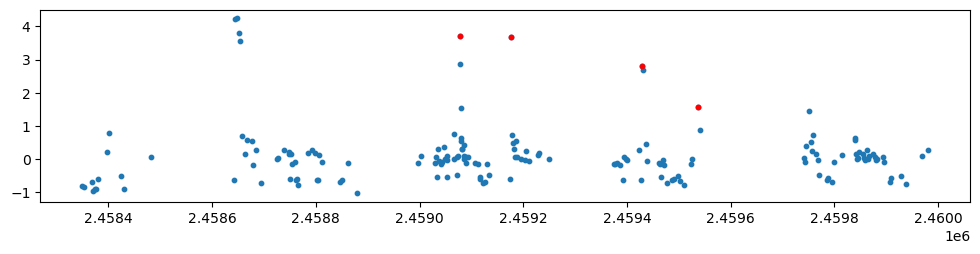

ZTF18acrsmyu UGSU


Number of peaks: 1 
Rise rate: 0.020358407235505548 
Decline rate: 0.007081803571355379 
Max prominence: 4.166479051159241


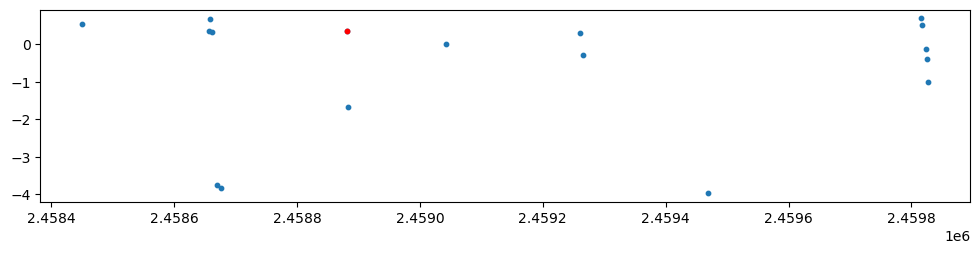

ZTF21abhrevv UGSU


Rolling std max: 2.2550323145472237 
Rolling std min: 0.07011816973849883 
Ratio of max and min of rolling std: 32.16045602669352 
Mean brightness of window with minimum rolling std: -0.1419404872526769
Standstill level: 0.043426487906132676
Number of peaks: 0 
Rise rate: nan 
Decline rate: nan 
Max prominence: nan


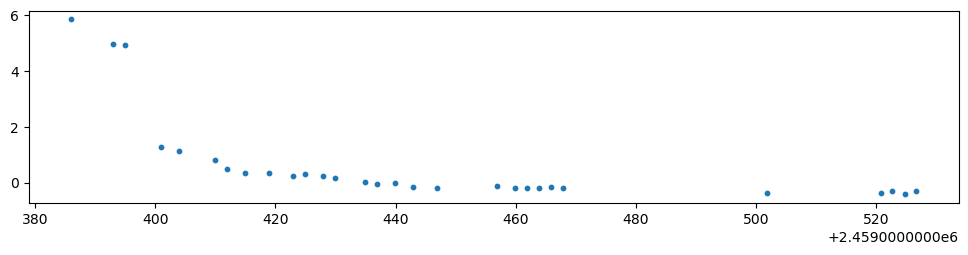

ZTF18abavrji UGER


Rolling std max: 1.3933608718149566 
Rolling std min: 0.12881418054420407 
Ratio of max and min of rolling std: 10.816828286516241 
Mean brightness of window with minimum rolling std: 0.08615546937861467
Standstill level: 0.9118206530501114
Number of peaks: 10 
Rise rate: 0.12643343808828725 
Decline rate: 0.08586640049141833 
Max prominence: 3.5252843414009547


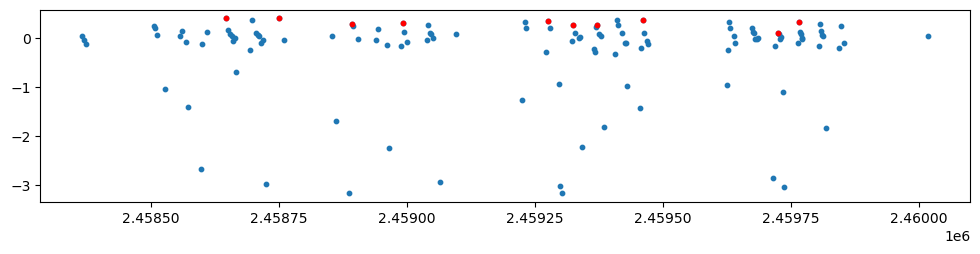

ZTF18aanwrti UGER


Rolling std max: 1.8431570321982476 
Rolling std min: 0.295576957263048 
Ratio of max and min of rolling std: 6.23579405263968 
Mean brightness of window with minimum rolling std: 1.2634234071615578
Standstill level: 0.8633348894804812
Number of peaks: 43 
Rise rate: 0.32952867525741864 
Decline rate: 0.21382883693335228 
Max prominence: 4.313802787420833


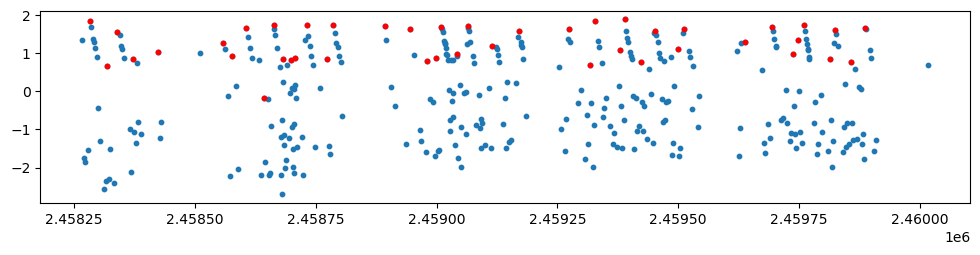

ZTF18aammncw UGER


Rolling std max: 1.3199522833512536 
Rolling std min: 0.1400483379408893 
Ratio of max and min of rolling std: 9.424976424271243 
Mean brightness of window with minimum rolling std: -0.3422622807147242
Standstill level: 0.2853131326701676
Number of peaks: 48 
Rise rate: 0.27547147102514685 
Decline rate: 0.16667854335947485 
Max prominence: 3.375207531732009


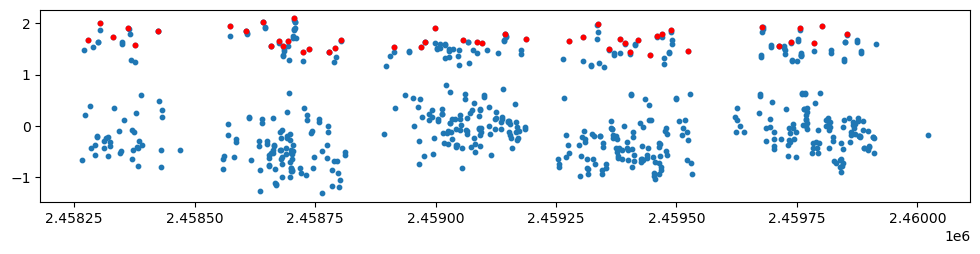

ZTF19abzzuin UG/IBWD


Number of peaks: 0 
Rise rate: nan 
Decline rate: nan 
Max prominence: nan


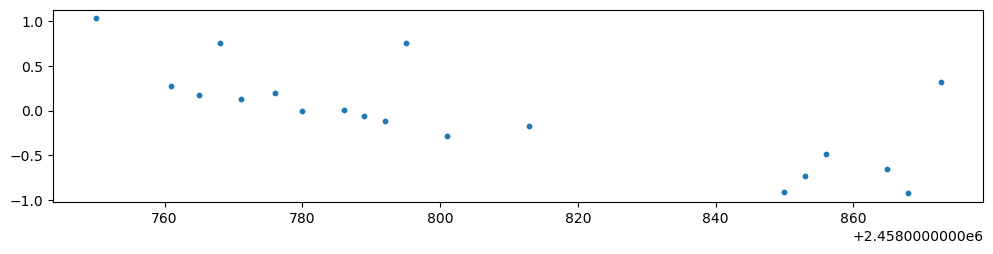

ZTF18acyerom UG/IBWD


Rolling std max: 2.5374166559349587 
Rolling std min: 0.07141279543128902 
Ratio of max and min of rolling std: 35.531680850897025 
Mean brightness of window with minimum rolling std: 0.055285005571107604
Standstill level: 0.11236713502379966
Number of peaks: 1 
Rise rate: 0.8599185972823445 
Decline rate: 0.0027055464494442744 
Max prominence: 2.587270104473605


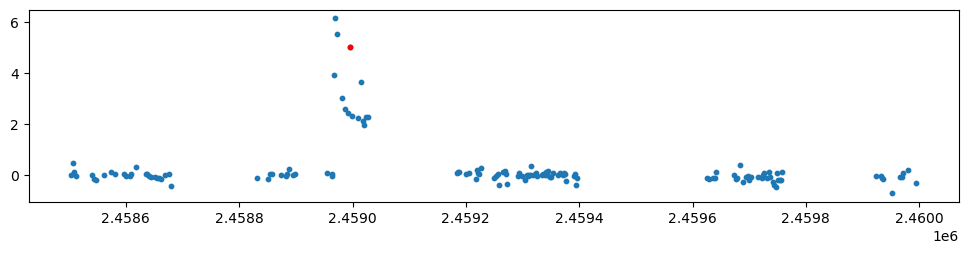

ZTF20abgbxco UGSU/IBWD


Rolling std max: 0.8182004306285195 
Rolling std min: 0.08016847301719766 
Ratio of max and min of rolling std: 10.206012411549862 
Mean brightness of window with minimum rolling std: -0.18129230320934298
Standstill level: 0.1302959018858492
Number of peaks: 1 
Rise rate: 0.458331198684492 
Decline rate: 0.03234821024620777 
Max prominence: 2.231287816192296


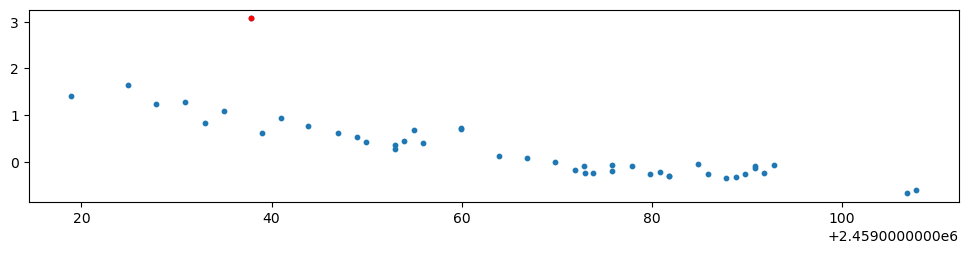

ZTF18achemir UGZ


Rolling std max: 1.3677059409934977 
Rolling std min: 0.3557668869376688 
Ratio of max and min of rolling std: 3.8443879720405882 
Mean brightness of window with minimum rolling std: -0.6044962735778064
Standstill level: 0.25161019380818367
Number of peaks: 33 
Rise rate: 0.31770401243037344 
Decline rate: 0.15279918173088144 
Max prominence: 3.264144598860959


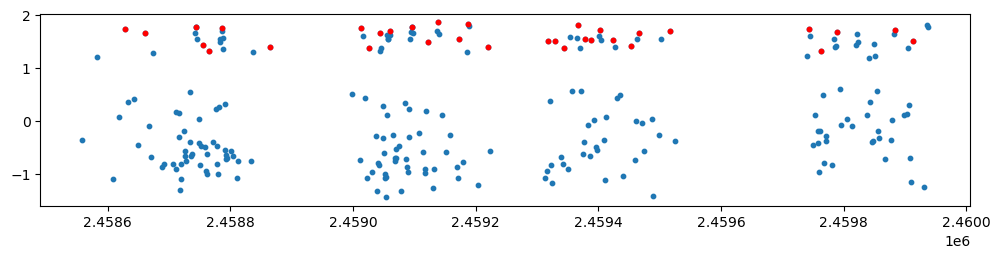

ZTF18abmaqoi UGZ


Rolling std max: 1.6073183489509617 
Rolling std min: 0.06072866847423018 
Ratio of max and min of rolling std: 26.4672088048994 
Mean brightness of window with minimum rolling std: 0.14880576212121638
Standstill level: 0.7361063218049196
Number of peaks: 31 
Rise rate: 0.47605906454611013 
Decline rate: 0.28992605997709414 
Max prominence: 3.8840751711767005


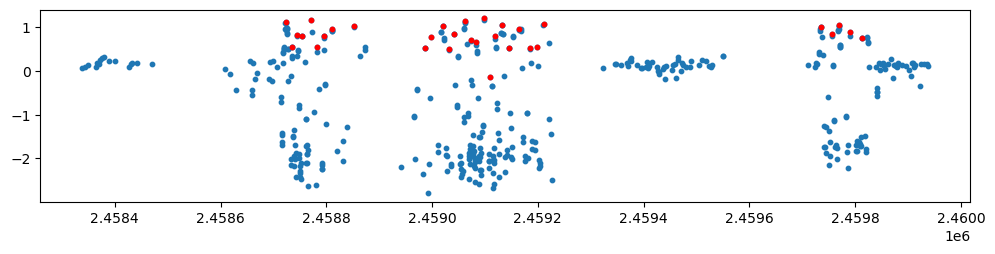

ZTF18adlkmio UGZ


Rolling std max: 0.6471122093670119 
Rolling std min: 0.05465686105578304 
Ratio of max and min of rolling std: 11.839542133723453 
Mean brightness of window with minimum rolling std: 0.03247808401189545
Standstill level: 0.6077923726609017
Number of peaks: 0 
Rise rate: nan 
Decline rate: 0.001486003692312408 
Max prominence: nan


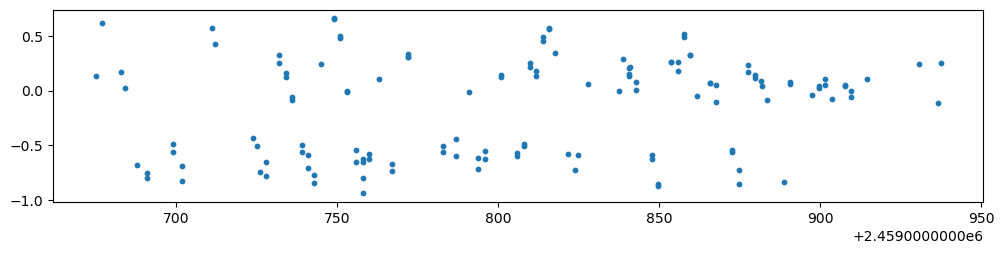

ZTF18abiwtyk UGZ


Rolling std max: 0.6479324489571732 
Rolling std min: 0.010125496981060626 
Ratio of max and min of rolling std: 63.99018736256672 
Mean brightness of window with minimum rolling std: 0.006093716428887319
Standstill level: 0.9112422033635785
Number of peaks: 0 
Rise rate: nan 
Decline rate: nan 
Max prominence: nan


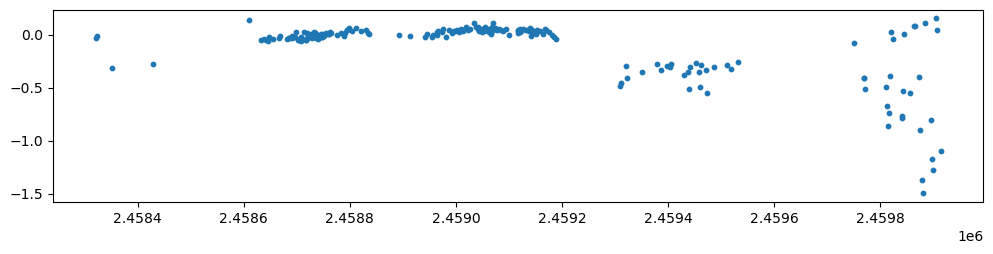

ZTF18aaueblh UGZ


Rolling std max: 0.34271617000353183 
Rolling std min: 0.014626950046613279 
Ratio of max and min of rolling std: 23.43046013771574 
Mean brightness of window with minimum rolling std: 0.04312807148418205
Standstill level: 0.9032858925297372
Number of peaks: 0 
Rise rate: nan 
Decline rate: nan 
Max prominence: nan


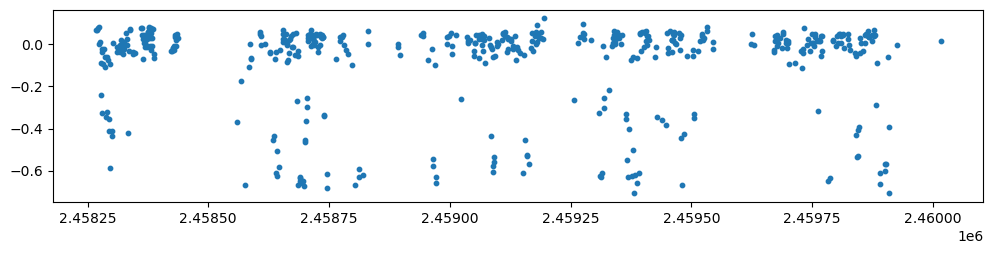

ZTF18aakvuwy UGZ


Rolling std max: 1.020218007233593 
Rolling std min: 0.05950636881086936 
Ratio of max and min of rolling std: 17.144685982708477 
Mean brightness of window with minimum rolling std: -0.3304217082453553
Standstill level: 0.6243695622469658
Number of peaks: 0 
Rise rate: nan 
Decline rate: nan 
Max prominence: nan


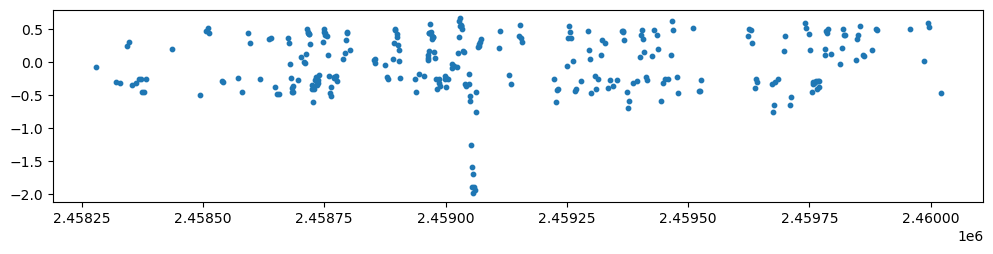

ZTF18abcnbki UGSS


Rolling std max: 2.3520958054702685 
Rolling std min: 0.029733266363720177 
Ratio of max and min of rolling std: 79.10653934544641 
Mean brightness of window with minimum rolling std: -0.10181499793044324
Standstill level: 0.09502431914220277
Number of peaks: 7 
Rise rate: 0.4322049587050742 
Decline rate: 0.0830164559561577 
Max prominence: 4.719255040909669


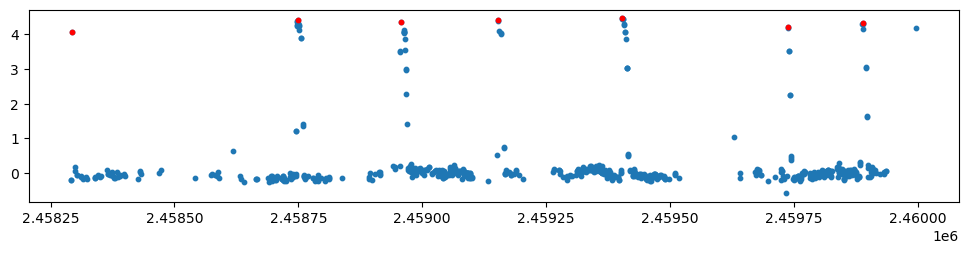

ZTF18abakkox UGSS


Rolling std max: 1.9852537647034056 
Rolling std min: 0.05025857076508233 
Ratio of max and min of rolling std: 39.500800251221655 
Mean brightness of window with minimum rolling std: 3.344535799198412
Standstill level: 0.9812415425554447
Number of peaks: 33 
Rise rate: 0.22694034372404048 
Decline rate: 0.16647807399976927 
Max prominence: 4.690419928367291


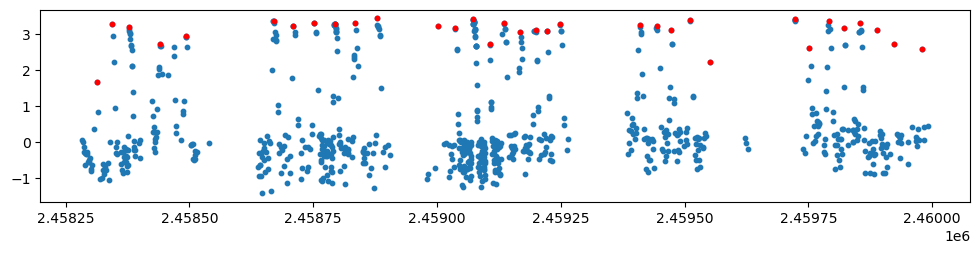

In [6]:
from scipy.signal import find_peaks
from scipy.stats import linregress
import numpy as np

# objlist = ['ZTF18aanwrti','ZTF18abmaqoi','ZTF18aabfcyi','ZTF18aakvuwy','ZTF18abajshu','ZTF20abgbxco','ZTF21abhrevv',
#            'ZTF18aagrgoe','ZTF18abchhxd']

for obj in objlist:
    type = df_ZTF_CVs[df_ZTF_CVs['Xmatch_obj']==obj]['Type'].iloc[0]
    print(obj, type)

    # Load and process lasair light curve
    lc_test = load_lasair_lc(oid=obj, path=f'../lightcurves_dataset/lasair_{date}')
    lc_appmag_test = lasair_clean(lc_test, limit=25, magerrlim=1)

    # Create a copy of the light curve
    lc = lc_appmag_test.copy()

     # Display light curve. Reversed or True for auto range.
    display_lightcurve(lc,x='jd',y='dc_mag',errorCol=errCollasair2, autorange='reversed')

    # Split light curve into g and r filters
    lc_g = lc[lc['fid']==1]
    lc_r = lc[lc['fid']==2]

    standstill_finder(lc_g, pnt_threshold=20, window_size=10)
    peak_definer(lc_g, height=None, threshold=None, distance=None, prominence=(2,5))

  

In [ ]:
# plot the lomb-scargle periodogram of the light curve
from astropy.timeseries import LombScargle
import matplotlib.pyplot as plt
import numpy as np
